# 0.0 Imports

In [8]:
import numpy as np
import pandas as pd
import scipy.stats as stats

from sklearn import model_selection as ms
from sklearn import preprocessing   as pp
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

#Visualization
from pandas_profiling import ProfileReport
from matplotlib import pyplot as plt
import seaborn as sns

#Others
import pickle
import warnings

from IPython.display       import Image
from IPython.core.display  import HTML

warnings.filterwarnings( 'ignore' )

"""pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

#Paths handlers
data_path = '/kaggle/input/inclusao-financeira-na-africa/' """

"pd.set_option('display.max_rows', 500)\npd.set_option('display.max_columns', 500)\npd.set_option('display.width', 1000)\n\nimport os\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n\n#Paths handlers\ndata_path = '/kaggle/input/inclusao-financeira-na-africa/' "

## 0.1. Helper Functions

In [18]:
def jupyter_settings():
    %matplotlib inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    
# Plots the disribution of a variable colored by value of the target
def kde_target(var_name, df):
    
    # Calculate the correlation coefficient between the new variable and the target
    corr = df['TARGET'].corr(df[var_name])
    
    # Calculate medians for repaid vs not repaid
    avg_repaid = df.ix[df['TARGET'] == 0, var_name].median()
    avg_not_repaid = df.ix[df['TARGET'] == 1, var_name].median()
    
    plt.figure(figsize = (12, 6))
    
    # Plot the distribution for target == 0 and target == 1
    sns.kdeplot(df.ix[df['TARGET'] == 0, var_name], label = 'TARGET == 0')
    sns.kdeplot(df.ix[df['TARGET'] == 1, var_name], label = 'TARGET == 1')
    
    # label the plot
    plt.xlabel(var_name); plt.ylabel('Density'); plt.title('%s Distribution' % var_name)
    plt.legend();
    
    # print out the correlation
    print('The correlation between %s and the TARGET is %0.4f' % (var_name, corr))
    # Print out average values
    print('Median value for loan that was not repaid = %0.4f' % avg_not_repaid)
    print('Median value for loan that was repaid =     %0.4f' % avg_repaid)


def diagnostic_plots(df, variable):
    # plot the histograms to have a quick look at the distributions
    # we can plot Q-Q plots to visualise if the variable is normally distributed
    # function to plot a histogram and a Q-Q plot
    # side by side, for a certain variable
    
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    df[variable].hist()

    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=pylab)

    plt.show()
    

jupyter_settings()

## 0.2 Loading Data

In [9]:
df_raw = pd.read_csv('csv/train.csv',low_memory=False)
test_raw = pd.read_csv('csv/test.csv',low_memory=False)

# 1.0. Descrição dos Dados

In [11]:
df_raw.head()

,country,year,uniqueid,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type,uid,bank_account
0,Rwanda,2016,uniqueid_4858,Rural,Yes,6,45,Male,Head of Household,Divorced/Seperated,Primary education,Farming and Fishing,Rwanda_uniqueid_4858,No
1,Tanzania,2017,uniqueid_3015,Urban,No,4,33,Female,Head of Household,Single/Never Married,Primary education,Self employed,Tanzania_uniqueid_3015,No
2,Rwanda,2016,uniqueid_103,Rural,Yes,7,43,Male,Head of Household,Married/Living together,Secondary education,Farming and Fishing,Rwanda_uniqueid_103,No
3,Rwanda,2016,uniqueid_4582,Rural,No,6,35,Female,Head of Household,Married/Living together,Primary education,Farming and Fishing,Rwanda_uniqueid_4582,No
4,Tanzania,2017,uniqueid_2854,Urban,Yes,2,30,Male,Head of Household,Single/Never Married,Primary education,Informally employed,Tanzania_uniqueid_2854,No


## 1.1. Data Dimensions and Columns

In [10]:
print(f'number of rows: {df_raw.shape[0]}')
print(f'number of columns: {df_raw.shape[1]}')

#df_raw.columns  # already in snake case! :)

number of rows: 11762
number of columns: 14


## 1.2. Data Types

In [13]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11762 entries, 0 to 11761
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   country                 11762 non-null  object
 1   year                    11762 non-null  int64 
 2   uniqueid                11762 non-null  object
 3   location_type           11762 non-null  object
 4   cellphone_access        11762 non-null  object
 5   household_size          11762 non-null  int64 
 6   age_of_respondent       11762 non-null  int64 
 7   gender_of_respondent    11762 non-null  object
 8   relationship_with_head  11762 non-null  object
 9   marital_status          11762 non-null  object
 10  education_level         11762 non-null  object
 11  job_type                11762 non-null  object
 12  uid                     11762 non-null  object
 13  bank_account            11762 non-null  object
dtypes: int64(3), object(11)
memory usage: 1.3+ MB


## 1.3. Check NA

In [14]:
df_raw.isna().sum()

country                   0
year                      0
uniqueid                  0
location_type             0
cellphone_access          0
household_size            0
age_of_respondent         0
gender_of_respondent      0
relationship_with_head    0
marital_status            0
education_level           0
job_type                  0
uid                       0
bank_account              0
dtype: int64

## 1.4 EDA

In [30]:
#EDA using pandas-profiling
profile = ProfileReport(df_raw, explorative=True)

#Saving results to a HTML file
profile.to_file("output.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 142.76it/s]


# 2.0 FEATURE ENGINEERING

In [31]:
df1 = df_raw.copy()
df1.head()

,country,year,uniqueid,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type,uid,bank_account
0,Rwanda,2016,uniqueid_4858,Rural,Yes,6,45,Male,Head of Household,Divorced/Seperated,Primary education,Farming and Fishing,Rwanda_uniqueid_4858,No
1,Tanzania,2017,uniqueid_3015,Urban,No,4,33,Female,Head of Household,Single/Never Married,Primary education,Self employed,Tanzania_uniqueid_3015,No
2,Rwanda,2016,uniqueid_103,Rural,Yes,7,43,Male,Head of Household,Married/Living together,Secondary education,Farming and Fishing,Rwanda_uniqueid_103,No
3,Rwanda,2016,uniqueid_4582,Rural,No,6,35,Female,Head of Household,Married/Living together,Primary education,Farming and Fishing,Rwanda_uniqueid_4582,No
4,Tanzania,2017,uniqueid_2854,Urban,Yes,2,30,Male,Head of Household,Single/Never Married,Primary education,Informally employed,Tanzania_uniqueid_2854,No


In [32]:
def idade(coluna):
    if coluna <= 26:
        return "Jovem"
    elif 26<coluna<=35:
        return "Jovem_Adulto"
    elif 35<coluna<=48:
        return "Adulto"
    else:
        return "Velho"

In [33]:
df1['age_of_respondent'] = df1['age_of_respondent'].map(idade)

## 2.1 Encoding Variables

In [34]:
df1['bank_account'] = df1['bank_account'].apply(lambda x: 1 if x=='Yes' else 0)
df1['gender_of_respondent'] = df1['gender_of_respondent'].apply(lambda x: 1 if x=='Male' else 0)
df1['location_type'] = df1['location_type'].apply(lambda x:1 if x=='Rural' else 0)
df1['cellphone_access'] = df1['cellphone_access'].apply(lambda x:1 if x=='Yes' else 0)

df1 = pd.get_dummies(df1, columns=['relationship_with_head'], prefix = ['rwh'])
df1 = pd.get_dummies(df1, columns=['age_of_respondent'], prefix = ['aor'])
df1 = pd.get_dummies(df1, columns=['marital_status'], prefix = ['ms'])
df1 = pd.get_dummies(df1, columns=['job_type'], prefix = ['jt'])
df1 = pd.get_dummies(df1, columns=['country'], prefix = ['c'])
#Label Encoder
df1['education_level'] = LabelEncoder().fit_transform(df1['education_level'].astype(str))


In [35]:
df1['household_size'] = np.log(df1.household_size)

In [36]:
df1.head()

,year,uniqueid,location_type,cellphone_access,household_size,gender_of_respondent,education_level,uid,bank_account,rwh_Child,rwh_Head of Household,rwh_Other non-relatives,rwh_Other relative,rwh_Parent,rwh_Spouse,aor_Adulto,aor_Jovem,aor_Jovem_Adulto,aor_Velho,ms_Divorced/Seperated,ms_Dont know,ms_Married/Living together,ms_Single/Never Married,ms_Widowed,jt_Dont Know/Refuse to answer,jt_Farming and Fishing,jt_Formally employed Government,jt_Formally employed Private,jt_Government Dependent,jt_Informally employed,jt_No Income,jt_Other Income,jt_Remittance Dependent,jt_Self employed,c_Kenya,c_Rwanda,c_Tanzania,c_Uganda
0,2016,uniqueid_4858,1,1,1.791759,1,2,Rwanda_uniqueid_4858,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1,2017,uniqueid_3015,0,0,1.386294,0,2,Tanzania_uniqueid_3015,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
2,2016,uniqueid_103,1,1,1.945910,1,3,Rwanda_uniqueid_103,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
3,2016,uniqueid_4582,1,0,1.791759,0,2,Rwanda_uniqueid_4582,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
4,2017,uniqueid_2854,0,1,0.693147,1,2,Tanzania_uniqueid_2854,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0


# 3.0 Data Preparation

## 3.1. Split dataframe  into training and testing

In [119]:
from sklearn.model_selection import train_test_split
Y = df1['bank_account'].copy()
X = df1.drop(['uniqueid', 'bank_account','uid','year','rwh_Head of Household',
              'rwh_Other non-relatives', 'rwh_Other relative', 'rwh_Other relative', 
              'rwh_Parent', 'rwh_Spouse'],axis=1)

In [40]:
#x_train,x_validation,y_train,y_validation = ms.train_test_split(X, y,test_size=0.75)
X_train, X_test, y_train,y_test = train_test_split(X,Y,train_size=0.75,stratify=Y,random_state=123)

## 3.2 Seleção de Features

In [84]:
from sklearn.ensemble import RandomForestClassifier
# Treinando modelo
model  = RandomForestClassifier()
model.fit(X_train, y_train)# Mostrando importância de cada feature
model_feature_importances = model.feature_importances_
model_feature_importances

Text(0.5, 1.0, 'Importância de cada feature')

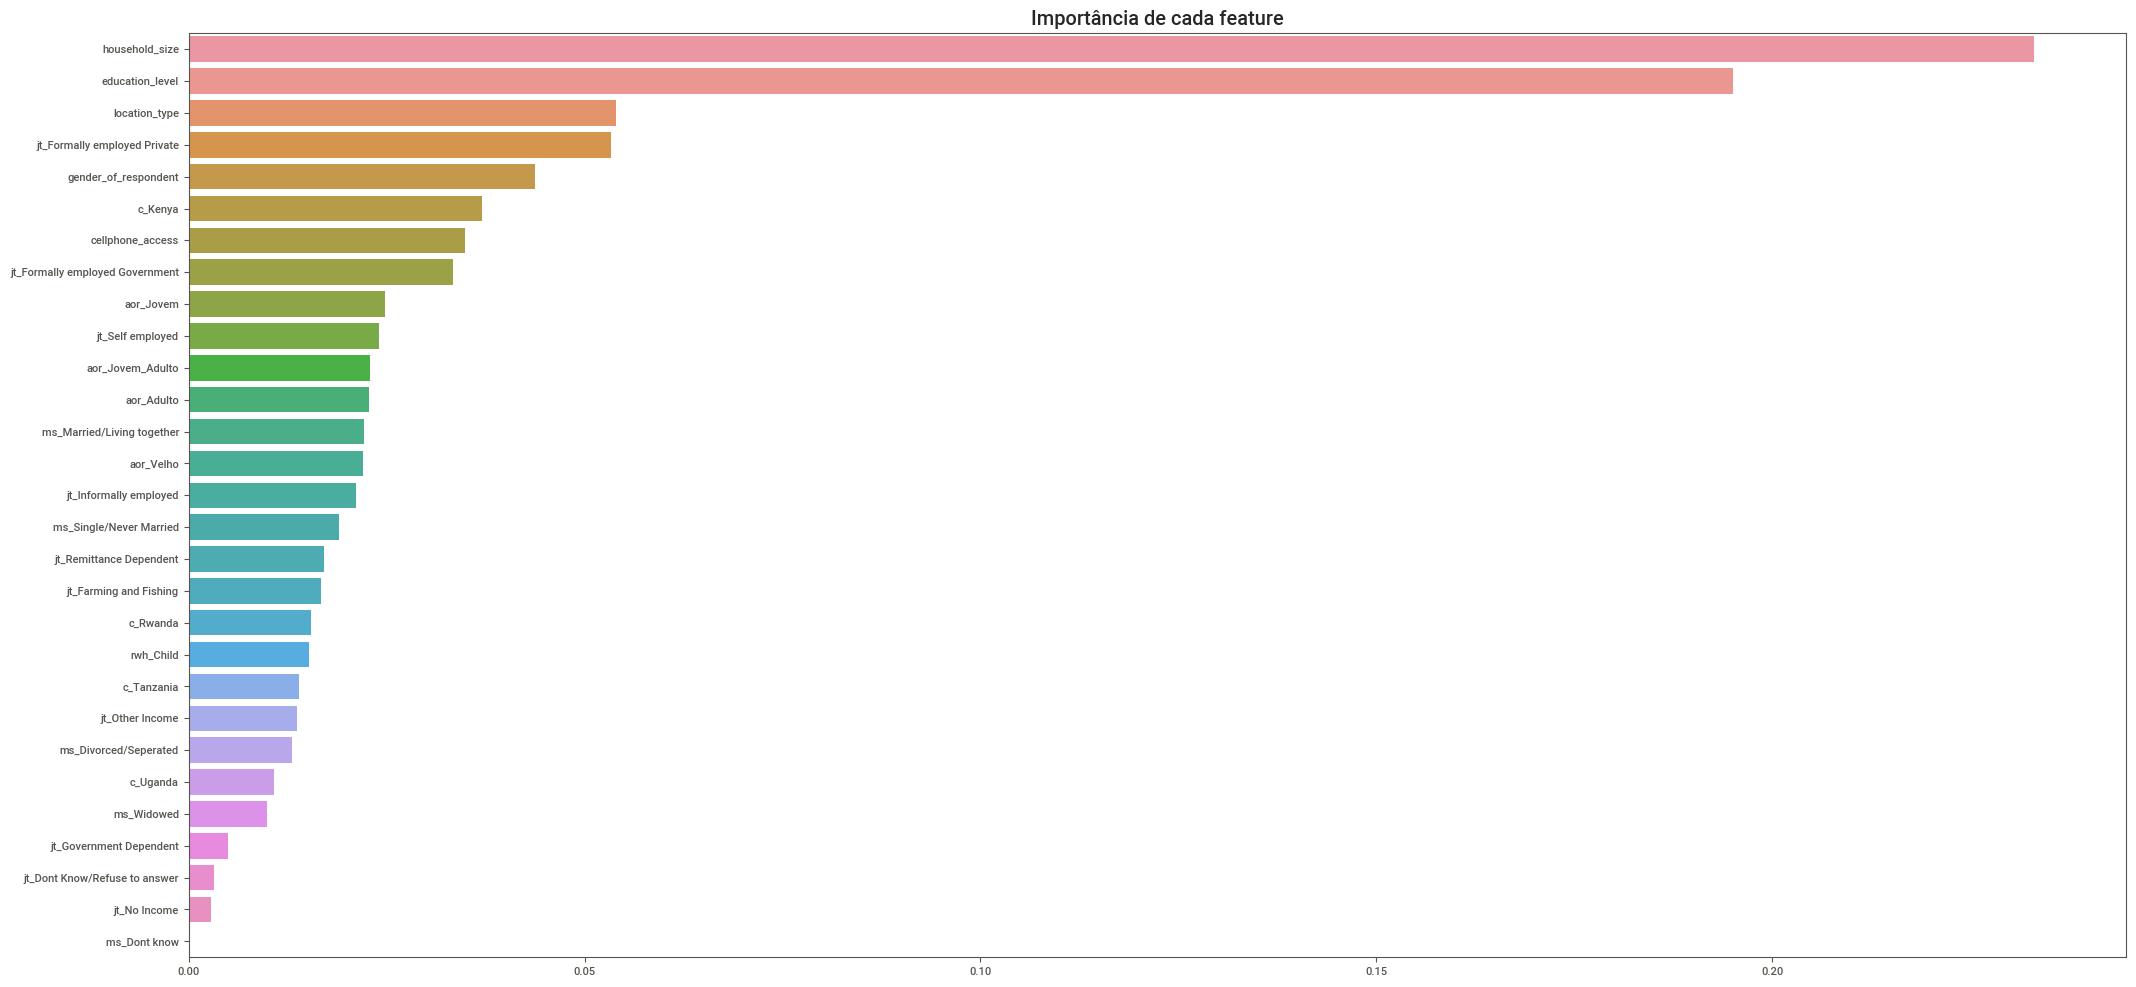

In [94]:
df_feat = df1.drop(['uniqueid', 'bank_account','uid','year','rwh_Head of Household',
              'rwh_Other non-relatives', 'rwh_Other relative', 'rwh_Other relative', 
              'rwh_Parent', 'rwh_Spouse'],axis=1)
importances = pd.Series(model_feature_importances, index=df_feat.columns)
importances = importances.sort_values(ascending=False)
sns.barplot(x=importances, y=importances.index, orient='h').set_title('Importância de cada feature')

In [108]:
#features selecionadas
df2 = df1[['household_size', 'education_level', 'location_type', 'jt_Formally employed Private', 'gender_of_respondent', 'c_Kenya', 'cellphone_access', 'jt_Formally employed Government',
'aor_Jovem', 'jt_Self employed', 'aor_Jovem_Adulto', 'aor_Adulto', 'ms_Married/Living together', 'aor_Velho', 'jt_Informally employed']]

In [128]:
cols_selected = ['household_size', 'education_level', 'location_type',
       'jt_Formally employed Private', 'gender_of_respondent', 'c_Kenya',
       'cellphone_access', 'jt_Formally employed Government', 'aor_Jovem',
       'jt_Self employed', 'aor_Jovem_Adulto', 'aor_Adulto',
       'ms_Married/Living together', 'aor_Velho', 'jt_Informally employed']

In [129]:
X_train = X_train[cols_selected]
X_test = X_test[cols_selected]

In [131]:
X_train.columns = ['household_size', 'education_level', 'location_type',
       'jt_formally_employed_private', 'gender_of_respondent', 'c_Kenya',
       'cellphone_access', 'jt_formally_employed_government', 'aor_Jovem',
       'jt_self_employed', 'aor_jovem_adulto', 'aor_adulto',
       'ms_married/living_together', 'aor_velho', 'jt_informally_employed']

X_test.columns = ['household_size', 'education_level', 'location_type',
       'jt_formally_employed_private', 'gender_of_respondent', 'c_Kenya',
       'cellphone_access', 'jt_formally_employed_government', 'aor_Jovem',
       'jt_self_employed', 'aor_jovem_adulto', 'aor_adulto',
       'ms_married/living_together', 'aor_velho', 'jt_informally_employed']

# 4.0 Machine Learning

In [134]:
from sklearn.ensemble import RandomForestClassifier
clf =  RandomForestClassifier(bootstrap=False, criterion="entropy", max_features=0.55, min_samples_leaf=9, min_samples_split=12, n_estimators=200)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, criterion='entropy', max_features=0.55,
                       min_samples_leaf=9, min_samples_split=12,
                       n_estimators=200)

In [135]:
y_pred=clf.predict(X_test)

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
print("Accuracy: %.2f%%" % (accuracy_score(y_test, y_pred)*100))
print("F1: %.2f%%" % (f1_score(y_test, y_pred)*100))

Accuracy: 88.24%
F1: 45.43%


In [137]:
import xgboost as xgb

model1 = xgb.XGBClassifier()
model2 = xgb.XGBClassifier(n_estimators=100, max_depth=8, learning_rate=0.1, subsample=0.5)
model3 = xgb.XGBClassifier(learning_rate= 0.01,
                            n_estimators=1500,
                            max_depth= 4,
                            subsample= 0.8,
                            colsample_bytree= 1,
                            gamma= 1)

In [141]:
model1.fit(X_train, y_train)
y_pred=model1.predict(X_test)
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
print("Accuracy: %.2f%%" % (accuracy_score(y_test, y_pred)*100))
print("F1: %.2f%%" % (f1_score(y_test, y_pred)*100))

Accuracy: 87.96%
F1: 45.03%


In [139]:
model2.fit(X_train, y_train)
y_pred=model2.predict(X_test)
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
print("Accuracy: %.2f%%" % (accuracy_score(y_test, y_pred)*100))
print("F1: %.2f%%" % (f1_score(y_test, y_pred)*100))

Accuracy: 88.10%
F1: 47.13%


In [140]:
model3.fit(X_train, y_train)
y_pred=model3.predict(X_test)

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
print("Accuracy: %.2f%%" % (accuracy_score(y_test, y_pred)*100))
print("F1: %.2f%%" % (f1_score(y_test, y_pred)*100))

Accuracy: 88.54%
F1: 46.25%


# 5.0 Test Submission

In [142]:
test = test_raw.copy()

In [143]:
test.sample()

,country,year,uniqueid,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type,uid
852,Kenya,2018,uniqueid_5457,Urban,No,3,58,Female,Head of Household,Divorced/Seperated,Secondary education,Remittance Dependent,Kenya_uniqueid_5457


## 5.1 Variable Encoding

In [144]:
test['age_of_respondent'] = test['age_of_respondent'].map(idade)

In [145]:

test['gender_of_respondent']=test['gender_of_respondent'].apply(lambda x: 1 if x=='Male' else 0)
test['location_type']=test['location_type'].apply(lambda x:1 if x=='Rural' else 0)
test['cellphone_access']=test['cellphone_access'].apply(lambda x:1 if x=='Yes' else 0)

test = pd.get_dummies(test, columns=['relationship_with_head'], prefix = ['rwh'])
test = pd.get_dummies(test, columns=['age_of_respondent'], prefix = ['aor'])

test = pd.get_dummies(test, columns=['marital_status'], prefix = ['ms'])
test = pd.get_dummies(test, columns=['job_type'], prefix = ['jt'])
test = pd.get_dummies(test, columns=['country'], prefix = ['c'])

test['education_level'] = LabelEncoder().fit_transform(test['education_level'].astype(str))


In [146]:
test['household_size'] = np.log(test.household_size)

## 5.2 Training Model

In [148]:
# Make a prediction using the XGboost model on the wanted columns
predictions = model3.predict(test[cols_selected])

KeyError: "['jt_formally_employed_private', 'jt_formally_employed_government', 'jt_self_employed', 'aor_jovem_adulto', 'aor_adulto', 'ms_married/living_together', 'aor_velho', 'jt_informally_employed'] not in index"

In [ ]:
submission = pd.DataFrame({'uid': test.uid, 'bank_account': predictions})

In [ ]:
submission.dtypes

In [ ]:
submission['bank_account'].value_counts()

In [ ]:
def yesno(coluna):
    if coluna == 0:
        return "No"
    else:
        return "Yes"

In [ ]:
submission['bank_account'] = submission['bank_account'].map(yesno)

In [ ]:
submission.sample(100)

In [ ]:
# Convert submisison dataframe to csv for submission to csv 
# for Kaggle submisison
submission.to_csv('/kaggle/working/submission.csv', index=False)
print('Submission CSV is ready!')